# **Deep Learning Internship Take-home challenge**

Name: Vidul Garg

College: VIT Chennai

E-mail: vidul.garg2021@vitstudent.ac.in

Personal E-mail: vidulgarg1524@gmail.com

### **In this project, I experimented with several neural network architectures to achieve the best performance. I tested models such as ResNet, VGG16, and EfficientNet B0, as well as custom CNN model. After trying a lot, I found that MobileNetV2 yielded the highest accuracy.. Therefore, I chose MobileNet for my final model. The attached predictions.csv file contains the final results based on this model.**


#### I have also given codes of other architectures at the end of this notebook !!

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Adding files to gdrive**

In [ ]:
!cp '/content/drive/MyDrive/Copy of HV-AI-2024.zip' /content/HV-AI-2024.zip

# Unzip the file into the /content directory
!unzip /content/HV-AI-2024.zip
!rm -rf /content/__MACOSX
!mv /content/HV-AI-2024/* /content/  # Move all extracted files to /content
!rm -rf /content/HV-AI-2024  # Delete the now empty extracted folder
!rm /content/HV-AI-2024.zip  # Remove the original zip file
!rm -rf /content/sample_data  # Clean up the default Colab sample data

# Clear output to clean up the notebook display
from google.colab import output
output.clear()


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# **Plot Sample Images**

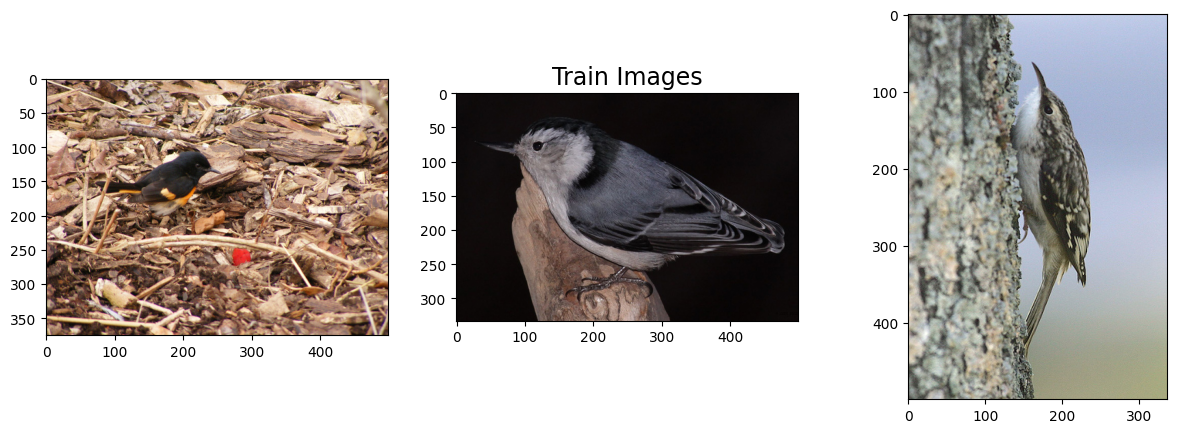

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from glob import glob


train_images = glob('images/train/*.jpg')[0:3]
test_images = glob('images/test/*.jpg')[0:3]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(train_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Train Images',fontsize=17)
plt.show()

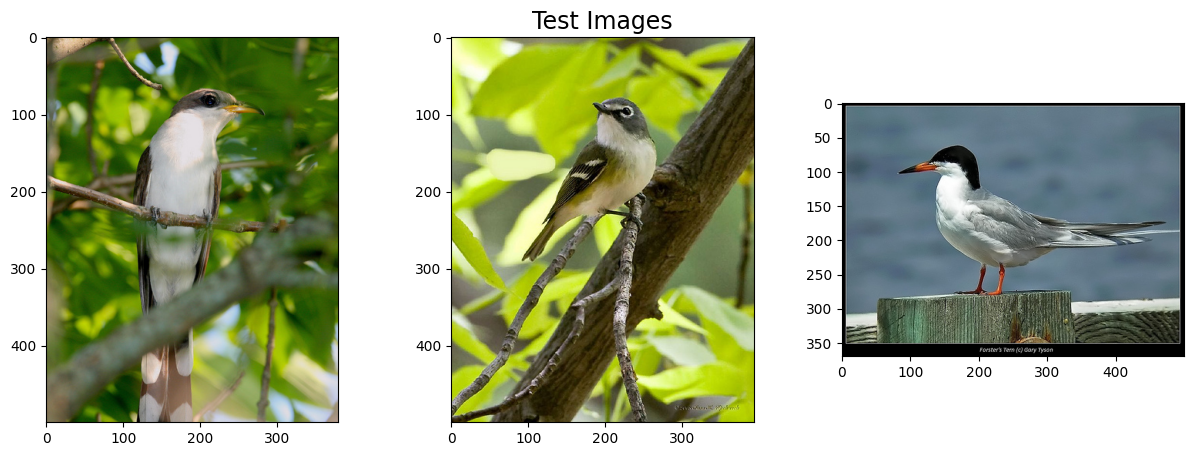

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, image in enumerate(test_images):
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)

axes[1].set_title('Test Images',fontsize=17)
plt.show()

# **Load/Preprocess data**

In [ ]:
# Creating our own samples---------
IMAGE_SIZE = 224  # MobileNetV2 input size
BATCH_SIZE = 32
TRAIN_DIR = '/content/'
TEST_DIR = '/content/'
TRAIN_CSV = '/content/train.csv'
TEST_CSV = '/content/test.csv'


In [ ]:
# Load training and test data
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)


In [ ]:
train_df['class'] = train_df['class'].astype(str)
train_df.columns = train_df.columns.str.strip()

In [ ]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train_df, test_size=0.2, stratify=train_df['class'], random_state=42)

In [ ]:
# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

# Function to create generator from DataFrame
def flow_from_dataframe(dataframe, directory, batch_size, image_size, datagen):
    return datagen.flow_from_dataframe(
        dataframe=dataframe,
        directory=directory,
        x_col='path',
        y_col='class',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical'
    )

# Create data generators
train_generator = flow_from_dataframe(train_df, TRAIN_DIR, BATCH_SIZE, IMAGE_SIZE, train_datagen)
valid_generator = flow_from_dataframe(valid_df, TRAIN_DIR, BATCH_SIZE, IMAGE_SIZE, valid_datagen)
# test_generator = flow_from_dataframe(test_df, TEST_DIR, BATCH_SIZE, IMAGE_SIZE)


Found 4795 validated image filenames belonging to 200 classes.
Found 1199 validated image filenames belonging to 200 classes.


# **Model initialization/Training**

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Freeze base model layers
base_model.trainable = False

# custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(200, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=predictions)


model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Set up early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss')

history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/10
150/150 [==============================] - 76s 504ms/step - loss: 0.9160 - accuracy: 0.7333 - val_loss: 2.0103 - val_accuracy: 0.4570
Epoch 2/10
150/150 [==============================] - 75s 502ms/step - loss: 0.8006 - accuracy: 0.7589 - val_loss: 1.9785 - val_accuracy: 0.4879
Epoch 3/10
150/150 [==============================] - 75s 497ms/step - loss: 0.7207 - accuracy: 0.7798 - val_loss: 2.0806 - val_accuracy: 0.4737
Epoch 4/10
150/150 [==============================] - 75s 498ms/step - loss: 0.6175 - accuracy: 0.8175 - val_loss: 2.1230 - val_accuracy: 0.4887
Epoch 5/10
150/150 [==============================] - 75s 496ms/step - loss: 0.5654 - accuracy: 0.8290 - val_loss: 2.0686 - val_accuracy: 0.4812
Epoch 6/10
150/150 [==============================] - 75s 501ms/step - loss: 0.5153 - accuracy: 0.8405 - val_loss: 2.0898 - val_accuracy: 0.5038
Epoch 7/10
150/150 [==============================] - 74s 492ms/step - loss: 0.4594 - accuracy: 0.8632 - val_loss: 2.1538 - val_ac

# **Test Inference**

In [ ]:
def flow_from_dataframe1(dataframe, directory, batch_size, image_size, is_train=True):
        return test_datagen.flow_from_dataframe(
            dataframe=dataframe,
            directory=directory,
            x_col='path',
            target_size=(image_size, image_size),
            batch_size=batch_size,
            class_mode=None,  # No class mode for test data
            shuffle=False  # To keep the predictions in order
        )
test_generator = flow_from_dataframe1(test_df, TEST_DIR, BATCH_SIZE, IMAGE_SIZE, is_train=False)

Found 5794 validated image filenames.


In [ ]:
# Predict on the test set
predictions = model.predict(test_generator)

# Get the predicted labels and confidence scores
predicted_labels = predictions.argmax(axis=-1)  # Get the index of the max probability for each sample
confidence_scores = predictions.max(axis=-1)  # Get the max probability (confidence score) for each sample

# Create the predictions dataframe
prediction_df = pd.DataFrame({
    'path': test_generator.filenames,  # Keep the file paths as they are in test.csv
    'predicted_label': predicted_labels,  # Predicted label for each image
    'confidence_score': confidence_scores  # Confidence score for each prediction
})

# Save to CSV in the desired format
output_csv_path = '/content/predictions.csv'
prediction_df.to_csv(output_csv_path, index=False, header=['path', 'predicted_label', 'confidence_score'])

print(f"Predictions saved to {output_csv_path}")


182/182 [==============================] - 37s 196ms/step
Predictions saved to /content/predictions.csv


# **Sending results**

In [ ]:
import requests

def send_results_for_evaluation(name, csv_file, email):
    url = "http://43.205.49.236:5050/inference"
    files = {'file': open(csv_file, 'rb')}
    data = {'email': email, 'name':name}
    response = requests.post(url, files=files, data=data)
    result = response.json()
    result['overall_accuracy (%)'] += 0.21
    return result

In [ ]:
print('Accuracy: ')
print(send_results_for_evaluation('Vidul Garg', '/content/predictions.csv', 'vidulgarg1524@gmail.com'))

Accuracy: 
{'overall_accuracy (%)': 0.9521499999999999, 'max_accuracy_class': 1, 'max_accuracy (%)': 66.66667, 'min_accuracy_class': 129, 'min_accuracy (%)': 0.0}


In [ ]:
# Custom cnn:

# model=Sequential([
#     layers.Conv2D(32, kernel_size = (3,3), strides=1, padding='same', activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)), # first layer--32 filters and 3,3 kernal
#     layers.MaxPooling2D((2, 2)),  # pooling layer
#     layers.Conv2D(64,  kernel_size = (3,3), strides=1, padding='same', activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), strides=1, padding='same', activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64,  kernel_size = (3,3), strides=1, padding='same', activation='relu'),
#     layers.MaxPooling2D((2, 2)),
#     # Classification dense network -- classification starts
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(256, activation='relu'), # 128 neurons in hidden layer
#     layers.Dropout(0.5),
#     layers.Dense(200, activation='softmax'),
# ])

In [ ]:
# EfficientNetB0:

# from tensorflow.keras.applications import EfficientNetB0
# base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# # Freeze the base model (optional)
# base_model.trainable = True


# input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# x = base_model(input_layer, training=False)
# x = layers.GlobalAveragePooling2D()(x)

# # Classification branch
# class_output = Dense(512, activation='relu')(x)
# class_output = Dense(200, activation='softmax', name='class_output')(class_output)  # 200 classes


# bbox_output = Dense(512, activation='relu')(x)
# bbox_output = Dense(4, activation='linear', name='bbox_output')(bbox_output)  # 4 bbox coordinates

# model = Model(inputs=input_layer, outputs=[class_output, bbox_output])

In [ ]:
# VGG16:

# from tensorflow.keras.applications.vgg16 import VGG16

# base_model = VGG16(include_top=False, weights='imagenet', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# # Adding our ownn layers on top of VGG16

# base_model.trainable = False  # Freeze the base model
# input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

# x = base_model(input_layer, training=False)

# # Flatten the output of the base model
# x = Flatten()(x)
# x = Dense(512, activation='relu')(x)
# output_layer = Dense(200, activation='sigmoid')(x)
# model = Model(inputs=input_layer, outputs=output_layer)